# Configurations

In [4]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

In [5]:
class CFG:
    
    epochs = 20                                        
    lr = 0.001                                         
    batch_size = 16                                    
    
    model_name = 'tf_efficientnet_b4_ns'               # Using efficientnet model from timm
    img_size = 224
    
    #Data Directories 
    DATA_DIR = 'C:\Projects\chest_xray'                      # Data Directory
    TEST = 'test'                                      # Test Directory
    TRAIN = 'train'                                    # Train Directory
    VAL ='val'                                         # Validation Directory
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On the device : {}".format(device))

On the device : cpu


# Image Transformation and Load Dataset 

In [6]:
from torchvision import transforms as T, datasets
from helper import show_image

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_transform = T.Compose([

    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(), #convert to tensor and (h,w,c) ---->(c,h,w)
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([

    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([

    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [8]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

In [9]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


{'NORMAL': 0, 'PNEUMONIA': 1}


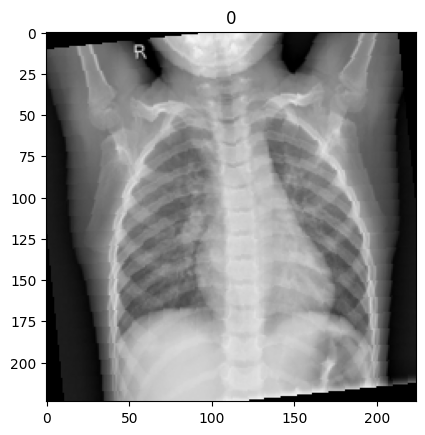

In [10]:
image,label = trainset[0]
print(trainset.class_to_idx)
show_image(image,label)

# Load Dataset into Batches 

In [11]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [12]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size , shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size , shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size , shuffle = True)

In [13]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of total examples : 5216


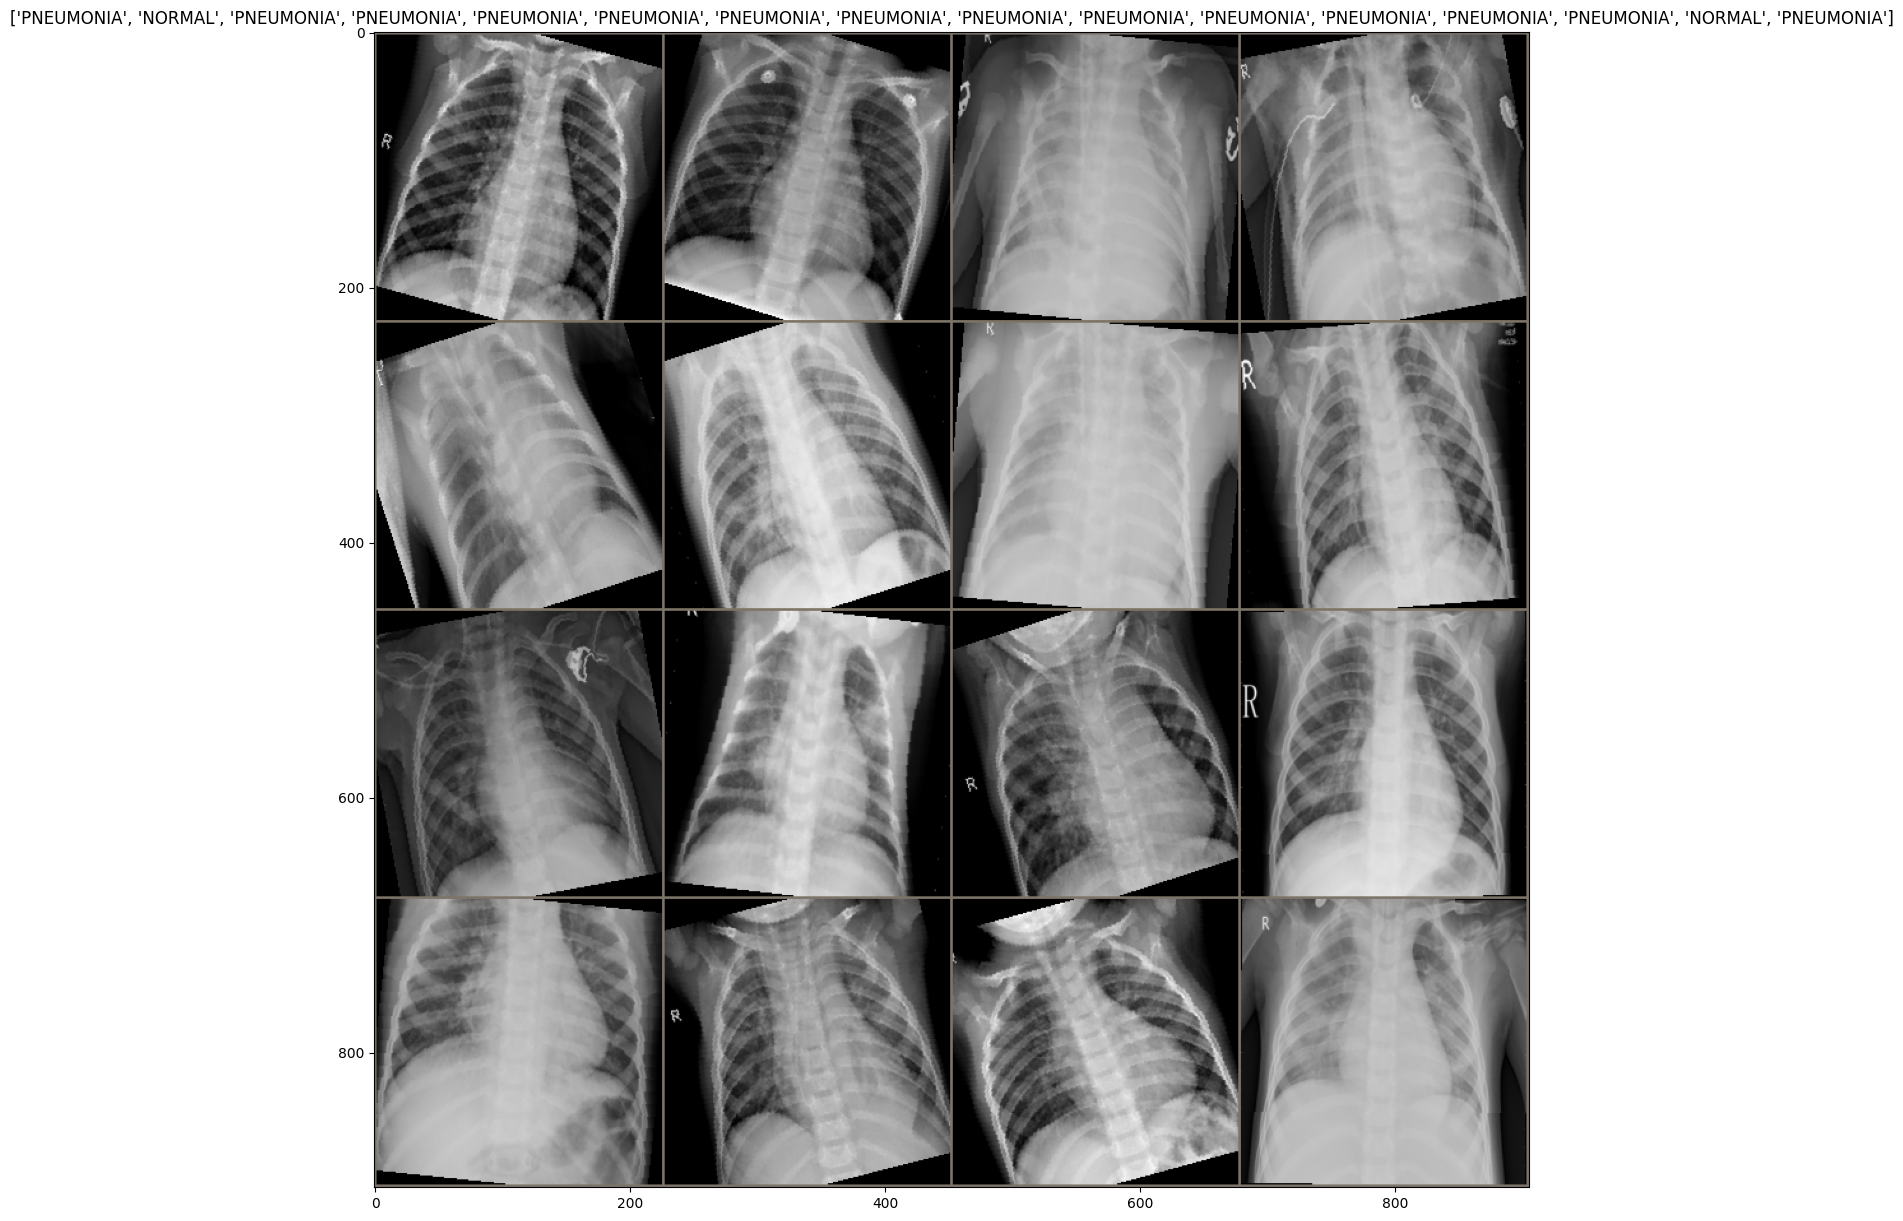

In [14]:
#Plotting one batch of images
dataiter = iter(trainloader)
images,labels = next(dataiter)
out = make_grid(images,nrow=4)
class_names = ['NORMAL','PNEUMONIA']
show_grid(out, title=[class_names[x] for x in labels])

# Fine tuning the EfficientNet Model 

In [15]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained = True)
model

c:\Python311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [16]:
#Fine tuning the model

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1792,625),
    nn.ReLU(),  
    nn.Dropout(0.3),
    nn.Linear(625,256),
    nn.ReLU(),
    nn.Linear(256,2)
)

model.to(device)

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [17]:
from torchsummary import summary 
summary(model,input_size= (3,CFG.img_size,CFG.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

# Trainer

In [18]:
from helper import accuracy
from tqdm import tqdm

In [19]:
class PneumoniaTrainer():

    def __init__(self,criterion = None,optimizer = None,schedular = None): #criterion = loss function, optimizer = optimizer function, schedular = learning rate schedular

        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular

    def train_batch_loop(self,model,trainloader):

        train_loss = 0.0
        train_acc = 0.0

        for images,labels in tqdm(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits,labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits,labels)

        return train_loss / len(trainloader), train_acc / len(trainloader)


    def valid_batch_loop(self,model,validloader):

        valid_loss = 0.0
        valid_acc = 0.0

        for images,labels in tqdm(validloader):

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits,labels)

            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)

        return valid_loss / len(validloader), valid_acc / len(validloader)


    def fit(self,model,trainloader,validloader,epochs):
        model = model.to(device)
        valid_min_loss = np.Inf

        for i in range(epochs):

            model.train() #Turn on dropout/batch norm
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader)

            model.eval() #Turn off dropout/batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)

            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'PneumoniaModel.pt')
                valid_min_loss = avg_valid_loss


            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

# Training

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validloader,epochs = CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


Valid_loss decreased inf --> 0.5033449530601501
Epoch : 1 Train Loss : 0.261495 Train Acc : 0.890721
Epoch : 1 Valid Loss : 0.503345 Valid Acc : 0.750000


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Valid_loss decreased 0.5033449530601501 --> 0.47804105281829834
Epoch : 2 Train Loss : 0.197819 Train Acc : 0.923313
Epoch : 2 Valid Loss : 0.478041 Valid Acc : 0.812500


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Epoch : 3 Train Loss : 0.188158 Train Acc : 0.920245
Epoch : 3 Valid Loss : 0.703803 Valid Acc : 0.562500


100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Epoch : 4 Train Loss : 0.187689 Train Acc : 0.923121
Epoch : 4 Valid Loss : 0.524603 Valid Acc : 0.562500


100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Valid_loss decreased 0.47804105281829834 --> 0.4680214524269104
Epoch : 5 Train Loss : 0.174287 Train Acc : 0.929448
Epoch : 5 Valid Loss : 0.468021 Valid Acc : 0.750000


100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Epoch : 6 Train Loss : 0.162325 Train Acc : 0.935008
Epoch : 6 Valid Loss : 0.559559 Valid Acc : 0.750000


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Valid_loss decreased 0.4680214524269104 --> 0.2899884581565857
Epoch : 7 Train Loss : 0.161147 Train Acc : 0.929640
Epoch : 7 Valid Loss : 0.289988 Valid Acc : 0.875000


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch : 8 Train Loss : 0.168594 Train Acc : 0.934433
Epoch : 8 Valid Loss : 0.330172 Valid Acc : 0.812500


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


Epoch : 9 Train Loss : 0.168738 Train Acc : 0.936158
Epoch : 9 Valid Loss : 0.552795 Valid Acc : 0.812500


100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Epoch : 10 Train Loss : 0.161273 Train Acc : 0.935008
Epoch : 10 Valid Loss : 0.483232 Valid Acc : 0.750000


100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Epoch : 11 Train Loss : 0.156441 Train Acc : 0.936541
Epoch : 11 Valid Loss : 0.590625 Valid Acc : 0.687500


100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


Epoch : 12 Train Loss : 0.155387 Train Acc : 0.937308
Epoch : 12 Valid Loss : 0.342598 Valid Acc : 0.875000


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


Epoch : 13 Train Loss : 0.147519 Train Acc : 0.940951
Epoch : 13 Valid Loss : 1.092458 Valid Acc : 0.500000


100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Epoch : 14 Train Loss : 0.141486 Train Acc : 0.944594
Epoch : 14 Valid Loss : 0.403511 Valid Acc : 0.750000


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


Epoch : 15 Train Loss : 0.151146 Train Acc : 0.937500
Epoch : 15 Valid Loss : 0.573448 Valid Acc : 0.687500


100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Epoch : 16 Train Loss : 0.140884 Train Acc : 0.942485
Epoch : 16 Valid Loss : 0.546129 Valid Acc : 0.750000


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Epoch : 17 Train Loss : 0.142376 Train Acc : 0.944402
Epoch : 17 Valid Loss : 0.472757 Valid Acc : 0.687500


100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


Epoch : 18 Train Loss : 0.137832 Train Acc : 0.943060
Epoch : 18 Valid Loss : 0.338593 Valid Acc : 0.875000


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Epoch : 19 Train Loss : 0.141230 Train Acc : 0.944785
Epoch : 19 Valid Loss : 0.448326 Valid Acc : 0.687500


100%|██████████| 1/1 [00:05<00:00,  5.42s/it]

Epoch : 20 Train Loss : 0.138688 Train Acc : 0.944785
Epoch : 20 Valid Loss : 0.866748 Valid Acc : 0.562500


# Plot Results 

In [21]:
from helper import view_classify

model.load_state_dict(torch.load('PneumoniaModel.pt',map_location = 'cpu'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))


100%|██████████| 39/39 [03:22<00:00,  5.20s/it]

Test Loss : 0.32935158297037465
Test Acc : 0.870192289352417


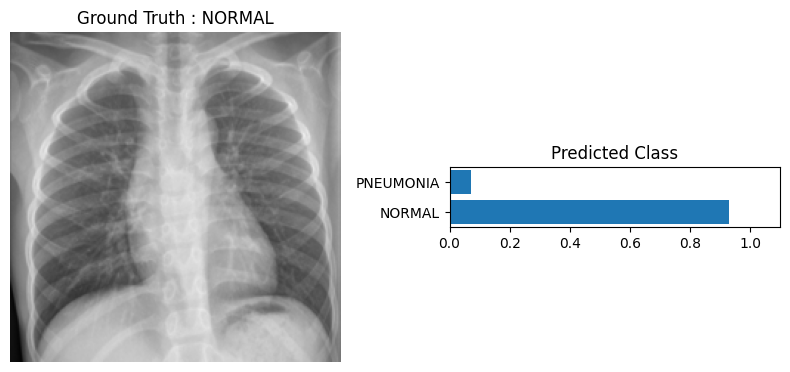

In [22]:
image,label = testset[3]

ps = model(image.unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)